In [9]:
# Importing Needed Libraries
import sys
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
class SmileDetectionModel:
    AUTOTUNE = tf.data.AUTOTUNE
    INITIAL_EPOCH = 10
    FINE_TUNE_AT = 20
    history = []

    def __init__(self, DATA_PATH, batchsize, shuffle, test_rate, validation_rate):

        # Loading the dataset
        self.dataset = tf.keras.utils.image_dataset_from_directory(DATA_PATH, batch_size=batchsize, shuffle=shuffle, image_size=(64, 64))
        test_batches = tf.data.experimental.cardinality(self.dataset)
        self.test_dataset = self.dataset.take(int(test_batches // test_rate))
        train_dataset = self.dataset.skip(int(test_batches // test_rate))
        val_batches = tf.data.experimental.cardinality(train_dataset)
        self.validation_dataset = self.dataset.take(int(val_batches // validation_rate))
        self.train_dataset = self.dataset.skip(int(val_batches // validation_rate))

        self.train_dataset = self.train_dataset.prefetch(buffer_size=self.AUTOTUNE)
        self.validation_dataset = self.validation_dataset.prefetch(buffer_size=self.AUTOTUNE)
        self.test_dataset = self.test_dataset.prefetch(buffer_size=self.AUTOTUNE)

    def data_augmentation(self, filp_augment=True, brightness_augment=True):
        layers = []

        if filp_augment:
            layers.append(tf.keras.layers.RandomFlip('horizontal'))
        if brightness_augment:
            layers.append(tf.keras.layers.RandomBrightness(0.3, value_range=(0, 255)))

        return tf.keras.Sequential(layers)

    def compile_model(self, data_augmentation):

        preprocess_input = tf.keras.applications.resnet50.preprocess_input
        base_model = tf.keras.applications.ResNet50(input_shape=(64, 64)+(3,), include_top=False, weights='imagenet')

        for layer in base_model.layers[:self.FINE_TUNE_AT]:
            layer.trainable = False

        Dense1 = tf.keras.layers.Dense(10)
        Dense2 = tf.keras.layers.Dense(20)
        outputlayer = tf.keras.layers.Dense(1)

        inputs = tf.keras.Input(shape=(64, 64)+(3,))
        x = data_augmentation(inputs) if data_augmentation else inputs
        x = preprocess_input(x)
        x = base_model(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = Dense1(x)
        x = tf.keras.activations.relu(x)
        x = Dense2(x)
        x = tf.keras.activations.relu(x)
        outputs = outputlayer(x)
        self.model = tf.keras.Model(inputs, outputs)

        self.model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                           metrics=['accuracy'])

    def train(self):
        new_history = self.model.fit(self.train_dataset, epochs=self.INITIAL_EPOCH,
                            validation_data=self.validation_dataset)

        self.history.append(new_history)

    def test(self):
        loss, accuracy = self.model.evaluate(self.dataset)
        return loss, accuracy

    def report(self):
        acc = self.history[-1].history['accuracy']
        val_acc = self.history[-1].history['val_accuracy']

        loss = self.history[-1].history['loss']
        val_loss = self.history[-1].history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()), 1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0, 1.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()


In [3]:
# Setting Genki dataset address
DATA_PATH = "/content/drive/MyDrive/IP_Project2/Genki New Dir"
BATCH_SIZE = 20
TEST_RATE = 3
VALID_RATE = 10
SHUFFLE = True

In [4]:
    classifier = SmileDetectionModel(DATA_PATH, BATCH_SIZE, SHUFFLE, TEST_RATE, VALID_RATE)
    data_augmentation = classifier.data_augmentation(filp_augment=True, brightness_augment=True)
    classifier.compile_model(data_augmentation)

Found 4000 files belonging to 2 classes.


In [5]:
classifier.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 64, 64, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 64, 64, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0     

In [6]:

    classifier.train()
    print("|----------------------- Model Trained -----------------------|\n")
    loss, accuracy = classifier.test()

Epoch 1/10
187/187 [==============================] - 76s 162ms/step - loss: 0.3021 - accuracy: 0.8607 - val_loss: 0.5773 - val_accuracy: 0.9231
Epoch 2/10
187/187 [==============================] - 23s 119ms/step - loss: 0.1755 - accuracy: 0.9374 - val_loss: 0.3204 - val_accuracy: 0.9115
Epoch 3/10
187/187 [==============================] - 22s 116ms/step - loss: 0.1515 - accuracy: 0.9449 - val_loss: 0.3625 - val_accuracy: 0.9000
Epoch 4/10
187/187 [==============================] - 25s 132ms/step - loss: 0.1211 - accuracy: 0.9561 - val_loss: 0.2894 - val_accuracy: 0.9231
Epoch 5/10
187/187 [==============================] - 34s 179ms/step - loss: 0.0931 - accuracy: 0.9663 - val_loss: 0.1347 - val_accuracy: 0.9500
Epoch 6/10
187/187 [==============================] - 25s 131ms/step - loss: 0.0842 - accuracy: 0.9668 - val_loss: 0.3273 - val_accuracy: 0.9231
Epoch 7/10
187/187 [==============================] - 35s 186ms/step - loss: 0.0776 - accuracy: 0.9749 - val_loss: 0.1732 - val_ac

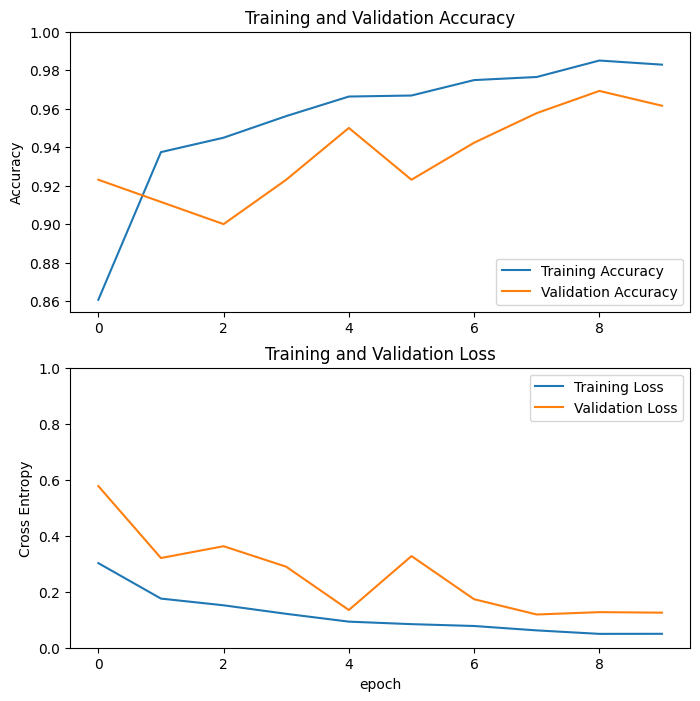

In [10]:
classifier.report()

In [7]:
classifier.model.save("CNN_Model.h5")